In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm 
from modules.datasets import MultiLabelDataset
from modules.siamese import ContrastiveNetwork
from modules.callbacks import LossTracker,ModelSaver
from modules.backbones import ResNet50,EfficientNetV2_L,MobilNetV3,DenseNet169,Swin
from modules.losses import TripletLoss
from modules.trainer import Trainer
import pytorch_lightning as pl
import gc

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") # we want to run Single-Core in the Notebook -> Ignore this warning
warnings.simplefilter(action='ignore', category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./runs/backbones"


C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For the Backbone-Tests we use 50 Classes

In [2]:
dataset = MultiLabelDataset(
    "./tiny-imagenet-200/train",
    cache_in_ram=True,
    #cache_path="./cache/tiny-imagenet-200/subset_of_10_classes_with_50_images",
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    max_classes=50
    )
contrastiveDataset = dataset #ContrastiveDataset(dataset,positives=1)
len(contrastiveDataset)

25000

In [3]:
#Build the DataLoaders
BATCH_SIZE = 128
train_size = int(0.8 * len(contrastiveDataset))
test_size = len(contrastiveDataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(contrastiveDataset, [train_size, test_size],generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,pin_memory=True)

In [4]:
#Train the Models
Epochs = 5
models = [ResNet50,EfficientNetV2_L,MobilNetV3,DenseNet169,Swin]
for model_definition in models: 
    model = model_definition(pretrained=True,freeze=False)
    siamese_model = ContrastiveNetwork(model,TripletLoss())
    
    model_dir = os.path.join(SAVE_DIR,type(model).__name__)
    if os.path.isdir(model_dir):
        continue
    os.makedirs(model_dir,exist_ok=True)
    
    lossTracker = LossTracker()
    modelSaver = ModelSaver(model_dir)
    
    trainer = Trainer(max_epochs=Epochs,callbacks=[lossTracker,modelSaver])
    trainer.fit(model=siamese_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    lossTracker.save(model_dir)
    torch.cuda.empty_cache()
    gc.collect()


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | ResNet50    | 24.7 M
1 | criterion | TripletLoss | 0     
------------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
49.379    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 197/197 [00:09<00:00, 20.70it/s, loss=0.0702, v_num=74]


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EfficientNetV2_L | 118 M 
1 | criterion | TripletLoss      | 0     
-----------------------------------------------
118 M     Trainable params
0         Non-trainable params
118 M     Total params
236.045   Total estimated model params size (MB)


Epoch 4: 100%|██████████| 197/197 [00:41<00:00,  4.77it/s, loss=0.0673, v_num=75]


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | MobilNetV3  | 3.6 M 
1 | criterion | TripletLoss | 0     
------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
7.193     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 197/197 [00:08<00:00, 22.40it/s, loss=0.0705, v_num=76]


Using cache found in C:\Users\Lukas/.cache\torch\hub\pytorch_vision_v0.10.0
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | DenseNet169 | 13.5 M
1 | criterion | TripletLoss | 0     
------------------------------------------
13.5 M    Trainable params
0         Non-trainable params
13.5 M    Total params
26.939    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 197/197 [00:24<00:00,  7.97it/s, loss=0.0633, v_num=77]


C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | Swin        | 87.4 M
1 | criterion | TripletLoss | 0     
------------------------------------------
87.4 M    Trainable params
0         Non-trainable params
87.4 M    Total params
174.801   Total estimated model params size (MB)


Epoch 4: 100%|██████████| 197/197 [01:44<00:00,  1.89it/s, loss=0.0609, v_num=78]


Build the KNN Indices for all the Models

In [5]:
from modules.knn import KNN

knns = {}

for model_definition in models: 
    model:torch.nn.Module = model_definition()
    model_name = type(model).__name__
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,model_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)
    knns[model_name] = KNN(model,train_loader,os.path.join(SAVE_DIR,model_name))

Building Embeddings: 100%|██████████| 157/157 [00:02<00:00, 69.90it/s]
Using cache found in C:\Users\Lukas/.cache\torch\hub\pytorch_vision_v0.10.0
Building Embeddings: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]


In [6]:
results = {}

for model_definition in models: 
    model:torch.nn.Module = model_definition()
    model_name = type(model).__name__
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,model_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)

    embeddings = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader,model_name):
            img,label = batch
            embedding = model(img.to(DEVICE)).cpu().numpy()
            embeddings.append(embedding)  
            labels.append(label)
    
    results[model_name] = (np.vstack(embeddings),np.vstack(labels).reshape(-1))


MobilNetV3: 100%|██████████| 40/40 [00:00<00:00, 68.73it/s]
Using cache found in C:\Users\Lukas/.cache\torch\hub\pytorch_vision_v0.10.0
Swin: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


Perform Prediction on the Test-Data

In [7]:
from sklearn.metrics import f1_score  

for key in results:
    embeddings,labels = results[key]
    predictions = knns[key].querry_labels(embeddings)
    print(f"{key} F1-Score: {f1_score(predictions,labels,average='macro'):.3f}")
        

ResNet50 F1-Score: 0.664
EfficientNetV2_L F1-Score: 0.540
MobilNetV3 F1-Score: 0.367
DenseNet169 F1-Score: 0.612
Swin F1-Score: 0.934


Visualize the t-SNE-Plot for the Test-Data

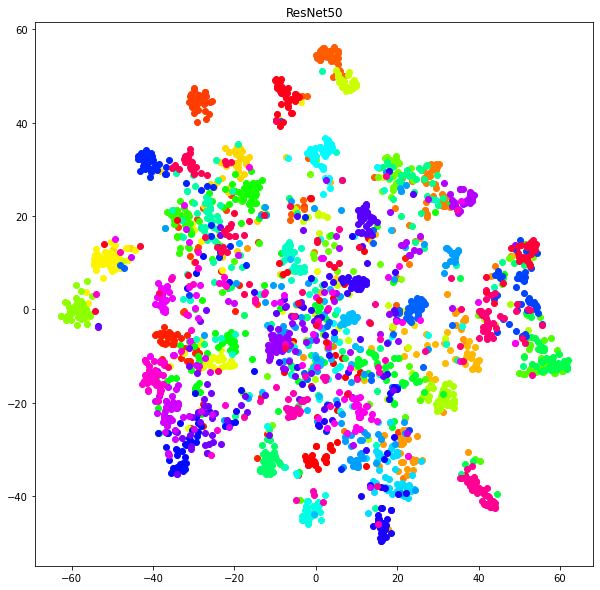

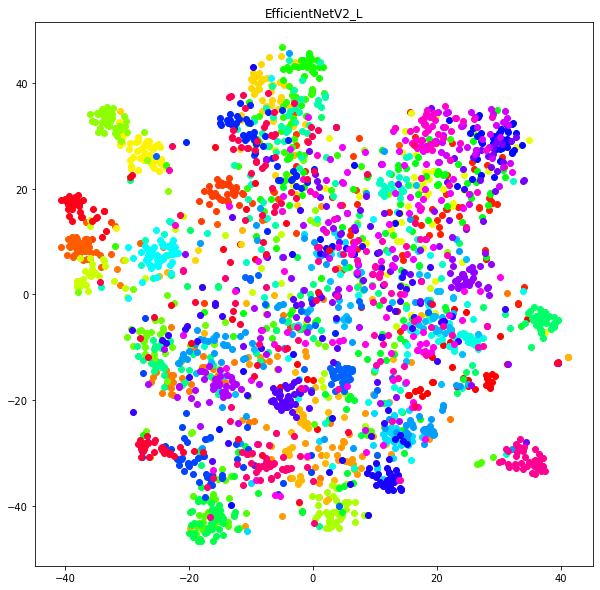

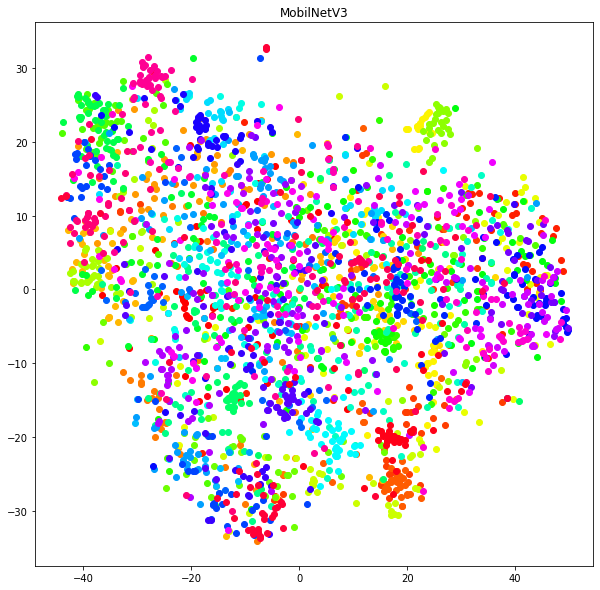

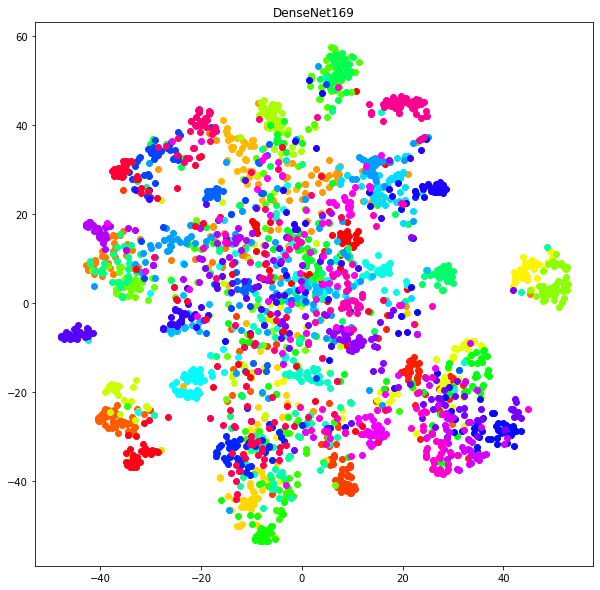

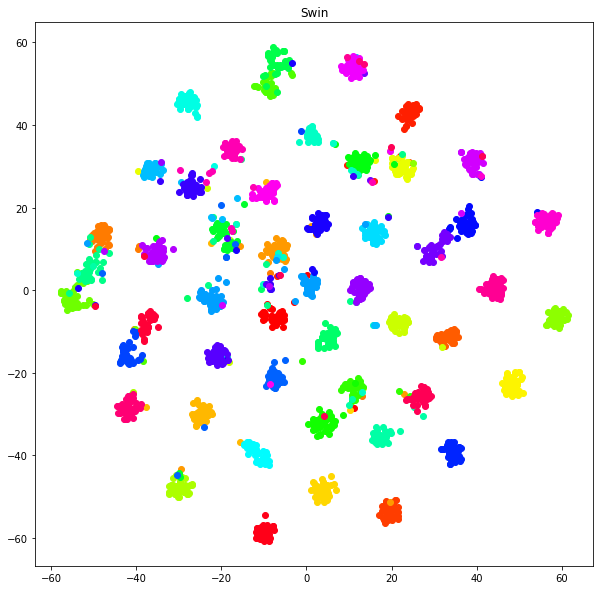

In [10]:
import matplotlib.pyplot as plt
from modules.plotting import plot_tsne

for key in results:
    embeddings,labels = results[key]
    plt.figure(figsize=(10,10))
    
    plot_tsne(embeddings,labels,50,max_points_per_class=50)
    plt.title(key)
    plt.show()